In [18]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

class MyMetric(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [21]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

class AccuracyMetric(tf.keras.metrics.Metric):
    def __init__(self, name='accuracy', **kwargs):
        super(AccuracyMetric, self).__init__(name=name, **kwargs)
        # 정확도 계산에 필요한 상태 변수
        self.correct_predictions = self.add_weight(name='correct_predictions', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true와 y_pred의 동일한 값을 찾아 맞춘 예측의 수를 증가시킵니다.
        y_true = tf.cast(y_true, dtype=tf.float16)
        y_pred = tf.cast(tf.round(y_pred), dtype=tf.float16)  # 예측 값을 0 또는 1로 반올림

        # 맞은 예측 수 계산
        matches = tf.equal(y_true, y_pred)
        self.correct_predictions.assign_add(tf.reduce_sum(tf.cast(matches, tf.float16)))
        
        # 전체 샘플 수 계산
        self.total_samples.assign_add(tf.cast(tf.size(y_true), tf.float16))

    def result(self):
        # 정확도를 계산 (맞은 예측 수 / 전체 샘플 수)
        return self.correct_predictions / self.total_samples

    def reset_state(self):
        # 상태를 초기화합니다.
        self.correct_predictions.assign(0)
        self.total_samples.assign(0)

In [31]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=1000)

def vectorize_sequences(sequences, dimension=1000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=[ AccuracyMetric()])

history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)


Epoch 1/20
30/30 [==============================] - 13s 426ms/step - loss: inf - accuracy: 0.4583 - val_loss: inf - val_accuracy: 0.4749
Epoch 2/20
30/30 [==============================] - 12s 419ms/step - loss: inf - accuracy: 0.4761 - val_loss: inf - val_accuracy: 0.4900
Epoch 3/20
30/30 [==============================] - 12s 419ms/step - loss: inf - accuracy: 0.4934 - val_loss: inf - val_accuracy: 0.5078
Epoch 4/20
30/30 [==============================] - 12s 419ms/step - loss: inf - accuracy: 0.5161 - val_loss: 5.5586 - val_accuracy: 0.5239
Epoch 5/20
30/30 [==============================] - 12s 419ms/step - loss: inf - accuracy: 0.5337 - val_loss: 3.9297 - val_accuracy: 0.5396
Epoch 6/20
30/30 [==============================] - 12s 419ms/step - loss: 3.2734 - accuracy: 0.5483 - val_loss: 2.8066 - val_accuracy: 0.5439
Epoch 7/20
30/30 [==============================] - 13s 422ms/step - loss: 2.3105 - accuracy: 0.5684 - val_loss: 1.9922 - val_accuracy: 0.5610
Epoch 8/20
30/30 [=====

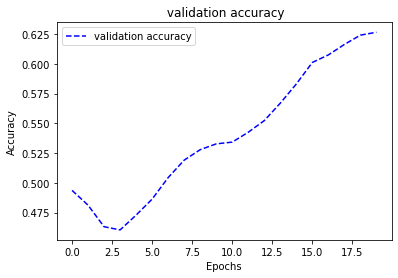

In [30]:
import matplotlib.pyplot as plt
val_acc = history_original.history["val_accuracy"]

epochs = range(10, 20)
plt.plot(val_acc, "b--", label="validation accuracy")
plt.title(" validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()